In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import optuna
from optuna.integration import XGBoostPruningCallback
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr


lgb_params = {'num_leaves': 17,
             'colsample_bytree': 0.7091234824890884,
             'reg_alpha': 0.7394476479071033,
             'reg_lambda': 7.808480534304585,
             'max_depth': 15,
             'learning_rate': 0.007814528175792283,
             'n_estimators': 2157,
             'min_child_samples': 11,
             'subsample': 0.7249013772087863}
xgb_params = {'eta': 0.9957304355968829, 
              'colsample_bynode': 0.40611009833532513, 
              'colsample_bytree': 0.9623288325539622, 
              'alpha': 0.28681293528875274, 
              'lambda': 4.94306107974444, 
              'gamma': 1, 
              'max_depth': 15, 
              'learning_rate': 0.002404371494323695, 
              'n_estimators': 3652, 
              'min_child_weight': 4, 
              'subsample': 0.5229951560076475}
cbc_params = {'iterations': 16548,
             'od_wait': 2242,
             'learning_rate': 0.07657517567155654,
             'reg_lambda': 52.990624904606946,
             'subsample': 0.39588132302781154,
             'random_strength': 22.033396044005116,
             'depth': 6,
             'min_data_in_leaf': 9,
             'leaf_estimation_iterations': 15,
             'bagging_temperature': 0.03433731559190882,
             'colsample_bylevel': 0.40040885299385404}

cbc_3_params = {'iterations': 7158,
             'od_wait': 1335,
             'learning_rate': 0.12935260228182627,
             'reg_lambda': 87.75727439439818,
             'subsample': 0.9069260712016368,
             'random_strength': 20.42688788081854,
             'depth': 9,
             'min_data_in_leaf': 4,
             'leaf_estimation_iterations': 11,
             'bagging_temperature': 30.43045701636414,
             'colsample_bylevel': 0.7624632990385846}

In [7]:
# Evaluation Metrics
def evaluation_metric(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def nrmse(y_true, y_pred):
    rmse_val = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse_val / (y_true.max() - y_true.min())

def test_error_percentage(score):
    return (score/4104996.104768301) * 100

def mae(y_true, y_pred):
    n = len(y_true)
    mae = sum(abs(y_true[i] - y_pred[i]) for i in range(n)) / n
    return mae

def test_rmse(y_true, y_pred):
    print(f"mae : {mae(y_true, y_pred)}")
    print(f"RMSE : {evaluation_metric(y_true, y_pred)}")
    print(f"Normalized RMSE : {nrmse(y_true, y_pred)}")
    score = evaluation_metric(y_true, y_pred)
    print(f"Error Percentage : {test_error_percentage(score)}")
    
def classify_level(value):
    if value <= 0.1:
        return 1
    elif value <= 0.3:
        return 2
    else:
        return 3


# Data Preprocessing
def preprocess_data(drop_data):
    train = pd.read_csv('train_data_nan_wind.csv', index_col='Date')
    test = pd.read_csv('test_data_nan_wind.csv', index_col='Date')
    train.fillna(-1, inplace=True)
    test.fillna(-1, inplace=True)
    all_data = pd.concat([train, test], ignore_index=True)

#     drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
#                     "PhenomenonNumber", "Humidity(%)", "Visibility(10m)", "aerosol", "power"]
    drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
                "PhenomenonNumber", "aerosol", "d2m", "VaporPressure(hPa)", "Humidity(%)", 
                    "Visibility(10m)", "MidLowCloudCoverage(1/10)", "LowCloud(100m)",
                   "SnowfallLast3Hours(cm)"]
#     drop_columns = ['Day', 'Precipitation(mm)',
#        'Humidity(%)', 'VaporPressure(hPa)', 'DewPointTemperature(C)',
#        'Sunshine(hr)', 'Snowfall(cm)',
#        'SnowfallLast3Hours(cm)', 'TotalCloudCoverage(1/10)',
#        'MidLowCloudCoverage(1/10)', 'CloudForm', 'LowCloud(100m)',
#        'Visibility(10m)', 'GroundState(code)', 'PhenomenonNumber', 'd2m',
#        't2m', 'aerosol', 'power', 'Year']
    all_data = all_data.drop(columns=drop_columns)
    all_data = all_data.drop(columns = drop_data)
    #all_data['num_missing'] = (all_data == -1).sum(axis=1)
    
    #all_data['Snowfall_Class'] = all_data['Snowfall(cm)'].apply(classify_level)
    #all_data['Precipitation_Class'] = all_data['Precipitation(mm)'].apply(classify_level)
    
    #all_data['Precipitation(mm)'] = all_data['Precipitation(mm)'] + 0.001
    #all_data['Precipitation(mm)'] = np.log1p(all_data['Precipitation(mm)'])
    
    #standard_cols = ['Sunshine(hr)', 'SolarRadiation(MJ/m2)', 'TotalCloudCoverage(1/10)', 'Snowfall(cm)']
    scaler = StandardScaler()
    #all_data[standard_cols] = scaler.fit_transform(all_data[standard_cols])

    all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data)], format='csr')
    num_train = len(train)
    X = all_data_sprs[:num_train]
    X_test = all_data_sprs[num_train:]
    y = train['power'].values
    y_test = test['power'].values
    return X, y, X_test, y_test

# Model Training and Prediction
def lgb_train_predict(model, params, X, y, X_test, eval_func):
    oof_val_preds = np.zeros(X.shape[0])
    oof_test_preds = np.zeros(X_test.shape[0])
    folds = TimeSeriesSplit(n_splits=5)
    for train_idx, valid_idx in folds.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        model_instance = model(**params)
        model_instance.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], callbacks = [lgb.early_stopping(stopping_rounds = 300, verbose = 0)])
        
        oof_val_preds[valid_idx] += model_instance.predict(X_valid)
        #oof_val_preds[valid_idx] = np.exp(oof_val_preds[valid_idx]) - 1
        
        #oof_test_preds += np.exp(model_instance.predict(X_test)) - 1
        oof_test_preds += model_instance.predict(X_test)
        
        score = evaluation_metric(y_valid, oof_val_preds[valid_idx])
        print(f"lgb fold RMSE: {score:.4f}")
        nrmse_score = nrmse(y_valid, oof_val_preds[valid_idx])
        print(f"lgb Normalized Validation RMSE: {nrmse_score:.4f}")
    oof_test_preds /= folds.n_splits
    return oof_val_preds, oof_test_preds

def xgb_train_predict(model, params, X, y, X_test, eval_func):
    oof_val_preds = np.zeros(X.shape[0])
    oof_test_preds = np.zeros(X_test.shape[0])
    folds = TimeSeriesSplit(n_splits=5)
    for train_idx, valid_idx in folds.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        model_instance = model(**params)
        model_instance.set_params(early_stopping_rounds = 300,eval_metric = 'rmse')
        model_instance.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose = False)
                           
        oof_val_preds[valid_idx] = model_instance.predict(X_valid)
        #oof_val_preds[valid_idx] = np.exp(oof_val_preds[valid_idx]) - 1
        
        #oof_test_preds += np.exp(model_instance.predict(X_test)) - 1
        oof_test_preds += model_instance.predict(X_test)
        
        score = evaluation_metric(y_valid, oof_val_preds[valid_idx])
        print(f"xgb fold RMSE: {score:.4f}")
        nrmse_score = nrmse(y_valid, oof_val_preds[valid_idx])
        print(f"xgb Normalized Validation RMSE: {nrmse_score:.4f}")
    oof_test_preds /= folds.n_splits
    return oof_val_preds, oof_test_preds

def cbc_train_predict(model, params, X, y, X_test, eval_func):
    oof_val_preds = np.zeros(X.shape[0])
    oof_test_preds = np.zeros(X_test.shape[0])
    folds = TimeSeriesSplit(n_splits=10)
    for train_idx, valid_idx in folds.split(X, y):
        X_train, y_train = X[train_idx], y[train_idx]
        X_valid, y_valid = X[valid_idx], y[valid_idx]
        model_instance = model(**params)
        model_instance.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose = False)
        oof_val_preds[valid_idx] += model_instance.predict(X_valid)
        #oof_val_preds[valid_idx] = np.exp(oof_val_preds[valid_idx]) - 1
        
        #oof_test_preds += np.exp(model_instance.predict(X_test)) - 1
        oof_test_preds += model_instance.predict(X_test)
        
        score = evaluation_metric(y_valid, oof_val_preds[valid_idx])
        print(f"cbc fold RMSE: {score:.4f}")
        nrmse_score = nrmse(y_valid, oof_val_preds[valid_idx])
        print(f"cbc Normalized Validation RMSE: {nrmse_score:.4f}")
    oof_test_preds /= folds.n_splits
    return oof_val_preds, oof_test_preds

# Ensemble Function
def ensemble_results(preds1, preds2, weights=(0.5, 0.5)):
    return preds1 * weights[0] + preds2 * weights[1]

def calculate_pearsonr(data1, data2):
    return pearsonr(data1, data2)

def daily_visualize(y_test_array, preds, test_index):
    # y_test와 test_index를 데이터프레임으로 변환
    y_test_df = pd.DataFrame(y_test_array, index=pd.to_datetime(test_index), columns=['power'])
    
    # 일자별로 그룹화하고 합계를 계산
    daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
    daily_predicted_sum = [np.sum(preds[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]
    
    # 상관계수 계산
    corr_coefficient, p_value = calculate_pearsonr(daily_actual_sum, daily_predicted_sum)

    plt.figure(figsize=(15, 6))
    plt.plot(daily_actual_sum, label='Actual Daily Power Sum', color='blue')
    plt.plot(daily_predicted_sum, label='Predicted Daily Power Sum', color='red', alpha=0.7)
    plt.title('Daily Power Sum')
    plt.ylabel('Power Sum')
    plt.legend()
    plt.grid(True, axis='y')
    
    # 상관계수를 그래프 상에 주석으로 추가
    corr_text = f"Pearson correlation coefficient: {corr_coefficient:.6f}\nP-value: {p_value:.6f}"
    plt.annotate(corr_text, xy=(0.75, 0.15), xycoords='axes fraction', fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="aliceblue"))

    plt.show()

    
def monthly_visualize(y_test_array, preds, test_index):
    # y_test와 test_index를 데이터프레임으로 변환
    y_test_df = pd.DataFrame(y_test_array, index=pd.to_datetime(test_index), columns=['power'])
    
    # 월별로 그룹화하고 합계를 계산
    monthly_actual_sum = y_test_df.resample('M').sum().values.flatten()
    monthly_predicted_sum = [np.sum(preds[(y_test_df.index.month == month) & (y_test_df.index.year == year)]) 
                             for year in y_test_df.index.year.unique() 
                             for month in range(1, 13) 
                             if (y_test_df.index.year.unique() == year).any() and 
                                (y_test_df.index.month == month).any()]
    
    plt.figure(figsize=(15, 6))
    plt.plot(monthly_actual_sum, label='Actual Monthly Power Sum', color='blue')
    plt.plot(monthly_predicted_sum, label='Predicted Monthly Power Sum', color='red', alpha=0.7)
    plt.title('Monthly Power Sum')
    plt.ylabel('Power Sum')
    plt.legend()
    plt.grid(True, axis='y')
    plt.show()

def monthly_error_bar_visualize_corrected(y_test_array, preds, test_index):
    # y_test와 test_index를 데이터프레임으로 변환
    y_test_df = pd.DataFrame(y_test_array, index=pd.to_datetime(test_index), columns=['power'])
    
    # 월별로 그룹화하고 합계를 계산
    monthly_actual_sum = y_test_df.resample('M').sum().values.flatten()
    monthly_predicted_sum = [np.sum(preds[y_test_df.index.month == month]) 
                             for month in range(1, 13)]
    
    # 오차 계산 (실제 값 - 예측 값)
    error = monthly_actual_sum - monthly_predicted_sum
    
    # 오차가 큰 상위 4개의 월을 찾아서 highlight하기 위한 리스트 생성
    highlight_months = np.argsort(np.abs(error))[-4:]
    
    # 그래프 생성
    plt.figure(figsize=(15, 6))
    bars = plt.bar(range(1, 13), error, color=['red' if i in highlight_months else 'blue' for i in range(12)])
    
    # 레이블, 제목, 범례 등 설정
    plt.xlabel('Month')
    plt.ylabel('Error (Actual - Predicted)')
    plt.title('Monthly Power Sum Error')
    plt.xticks(range(1, 13))
    plt.legend([bars[i] for i in highlight_months], ['Top {} error month'.format(i+1) for i in range(4)])
    plt.grid(True, axis='y')
    plt.tight_layout()
    
    plt.show()


In [8]:
columnss = ['Month', 'Hour', 'Temperature(C)', 'Precipitation(mm)',
       'DewPointTemperature(C)', 'Sunshine(hr)', 'SolarRadiation(MJ/m2)',
       'Snowfall(cm)', 'TotalCloudCoverage(1/10)', 'Wind_Speed']

for column in columnss:
    
    X, y, X_test, y_test = preprocess_data(column)
    print(f"drop {column}")

    lgb_oof_val_preds, lgb_oof_test_preds = lgb_train_predict(LGBMRegressor, lgb_params, X, y, X_test, evaluation_metric)
    xgb_oof_val_preds, xgb_oof_test_preds = xgb_train_predict(XGBRegressor, xgb_params, X, y, X_test, evaluation_metric)
    cbc_oof_val_preds, cbc_oof_test_preds = cbc_train_predict(CatBoostRegressor, cbc_params, X, y, X_test, evaluation_metric)
    #cbc_3_oof_val_preds, cbc_3_oof_test_preds = cbc_train_predict(CatBoostRegressor, cbc_3_params, X, y, X_test, evaluation_metric)
    #ensemble_preds = ensemble_results(lgb_oof_test_preds, xgb_oof_test_preds, weights=(0.2, 0.8))
    test_rmse(y_test, lgb_oof_test_preds)
    test_rmse(y_test, xgb_oof_test_preds)
    test_rmse(y_test, cbc_oof_test_preds)
    #test_rmse(y_test, cbc_3_oof_test_preds)
    #daily_visualize(y_test, ensemble_preds)

drop Month
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1227
[LightGBM] [Info] Number of data points in the train set: 5791, number of used features: 10
[LightGBM] [Info] Start training from score 4221853.220515
lgb fold RMSE: 87440.6228
lgb Normalized Validation RMSE: 0.0074
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 11581, number of used features: 10
[LightGBM] [Info] Start training from score 4082546.515845
lgb fold RMSE: 67710.2385
lgb Normalized Validation RMSE: 0.0056
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_col_wise=true` to remove the ove

lgb fold RMSE: 73039.6859
lgb Normalized Validation RMSE: 0.0059
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1121
[LightGBM] [Info] Number of data points in the train set: 28951, number of used features: 10
[LightGBM] [Info] Start training from score 4070511.633450
lgb fold RMSE: 70666.0267
lgb Normalized Validation RMSE: 0.0059
xgb fold RMSE: 132676.1191
xgb Normalized Validation RMSE: 0.0112
xgb fold RMSE: 92617.7103
xgb Normalized Validation RMSE: 0.0077
xgb fold RMSE: 89120.5260
xgb Normalized Validation RMSE: 0.0073
xgb fold RMSE: 65694.6829
xgb Normalized Validation RMSE: 0.0053
xgb fold RMSE: 78760.3389
xgb Normalized Validation RMSE: 0.0066
cbc fold RMSE: 136944.9770
cbc Normalized Validation RMSE: 0.0112
cbc fold RMSE: 89750.9556
cbc Normalized Validation RMSE: 0.007

cbc fold RMSE: 33347.8276
cbc Normalized Validation RMSE: 0.0027
cbc fold RMSE: 41508.5214
cbc Normalized Validation RMSE: 0.0034
cbc fold RMSE: 47588.3844
cbc Normalized Validation RMSE: 0.0040
cbc fold RMSE: 29254.6724
cbc Normalized Validation RMSE: 0.0025
mae : 55491.71172372508
RMSE : 83542.85640527327
Normalized RMSE : 0.00687935247078996
Error Percentage : 2.0351506864581714
mae : 53280.029587656136
RMSE : 105396.42785485288
Normalized RMSE : 0.00867888898673031
Error Percentage : 2.567515904154598
mae : 23027.672489107175
RMSE : 50070.72796536632
Normalized RMSE : 0.004123083659862181
Error Percentage : 1.2197509251520344
drop Sunshine(hr)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 5791, number of used features: 10
[LightGBM] [Info] Start training from score 4221853.2

lgb fold RMSE: 71924.4267
lgb Normalized Validation RMSE: 0.0060
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 17371, number of used features: 10
[LightGBM] [Info] Start training from score 3998058.424961
lgb fold RMSE: 70201.1258
lgb Normalized Validation RMSE: 0.0057
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 23161, number of used features: 10
[LightGBM] [Info] Start training from score 4059523.643193
lgb fold RMSE: 71291.8087
lgb Normalized Validation RMSE: 0.0058
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001640 secon

lgb fold RMSE: 66223.2877
lgb Normalized Validation RMSE: 0.0055
xgb fold RMSE: 130029.8503
xgb Normalized Validation RMSE: 0.0110
xgb fold RMSE: 99747.5285
xgb Normalized Validation RMSE: 0.0083
xgb fold RMSE: 83503.2825
xgb Normalized Validation RMSE: 0.0068
xgb fold RMSE: 65566.7242
xgb Normalized Validation RMSE: 0.0053
xgb fold RMSE: 78478.7093
xgb Normalized Validation RMSE: 0.0065
cbc fold RMSE: 130599.6376
cbc Normalized Validation RMSE: 0.0106
cbc fold RMSE: 86609.0061
cbc Normalized Validation RMSE: 0.0073
cbc fold RMSE: 42641.5299
cbc Normalized Validation RMSE: 0.0037
cbc fold RMSE: 45036.8968
cbc Normalized Validation RMSE: 0.0038
cbc fold RMSE: 39749.8058
cbc Normalized Validation RMSE: 0.0033
cbc fold RMSE: 40874.9251
cbc Normalized Validation RMSE: 0.0035
cbc fold RMSE: 34360.1516
cbc Normalized Validation RMSE: 0.0028
cbc fold RMSE: 44423.3403
cbc Normalized Validation RMSE: 0.0036
cbc fold RMSE: 38083.9210
cbc Normalized Validation RMSE: 0.0032
cbc fold RMSE: 27181.12

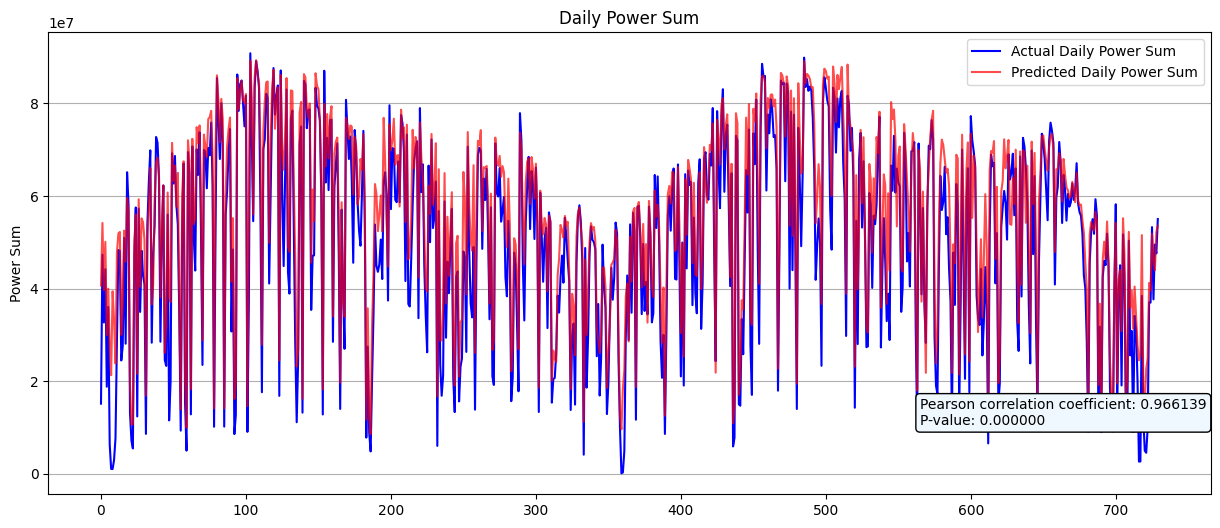

In [26]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, xgb_oof_test_preds, test.index)

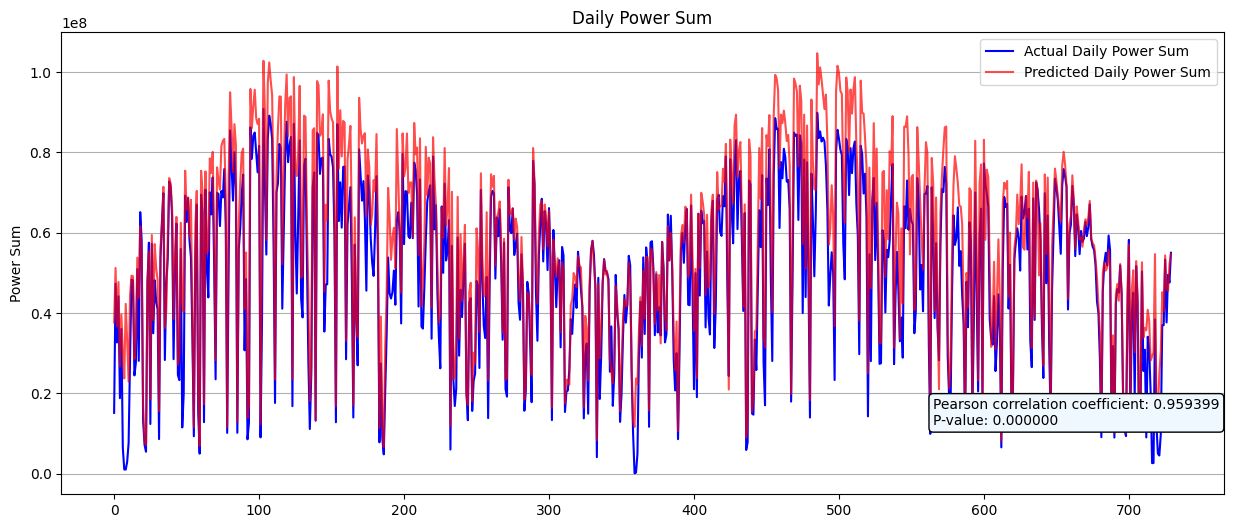

In [20]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')
daily_visualize(y_test, cbc_oof_test_preds, test.index)

# 오차 분석

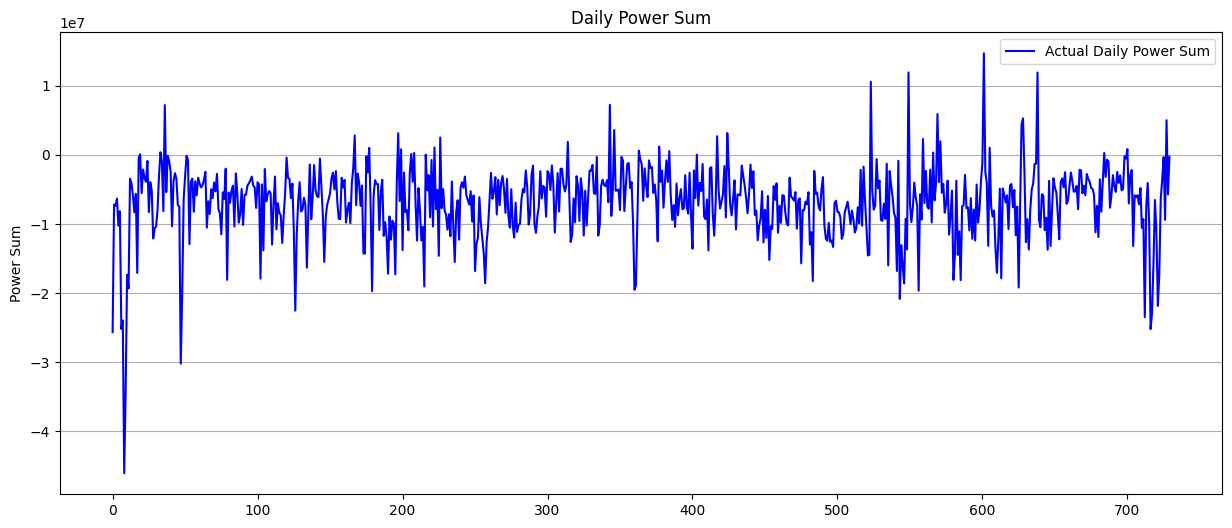

In [28]:
test = pd.read_csv('test_data_nan.csv', index_col='DateTime')

y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])

# 일자별로 그룹화하고 합계를 계산
daily_actual_sum = y_test_df.groupby(y_test_df.index.date)['power'].sum().values
daily_predicted_sum = [np.sum(cbc_oof_test_preds[y_test_df.index.date == date]) for date in np.unique(y_test_df.index.date)]

plt.figure(figsize=(15, 6))
plt.plot(daily_actual_sum - daily_predicted_sum, label='Actual Daily Power Sum', color='blue')
plt.title('Daily Power Sum')
plt.ylabel('Power Sum')
plt.legend()
plt.grid(True, axis='y')
plt.show()

In [6]:
# 오차 계산
error = daily_actual_sum - daily_predicted_sum

# 오차와 관련된 날짜 정보를 데이터프레임으로 만들기
error_df = pd.DataFrame({
    'date': np.unique(y_test_df.index.date),
    'error': error
})

# 오차를 내림차순으로 정렬
sorted_error_df = error_df.sort_values(by='error', ascending=False)

# 상위 10개의 오차를 가진 날짜 선택
top_10_error_dates = sorted_error_df.head(10)
top_10_error_dates

,date,error
638,2022-10-01,2.341363e+06
718,2022-12-20,7.075308e+05
11,2021-01-12,6.670158e+05
64,2021-03-06,5.972574e+05
648,2022-10-11,5.896147e+05
642,2022-10-05,5.208952e+05
523,2022-06-08,4.057429e+05
647,2022-10-10,3.985128e+05
521,2022-06-06,3.108255e+05
641,2022-10-04,3.066329e+05


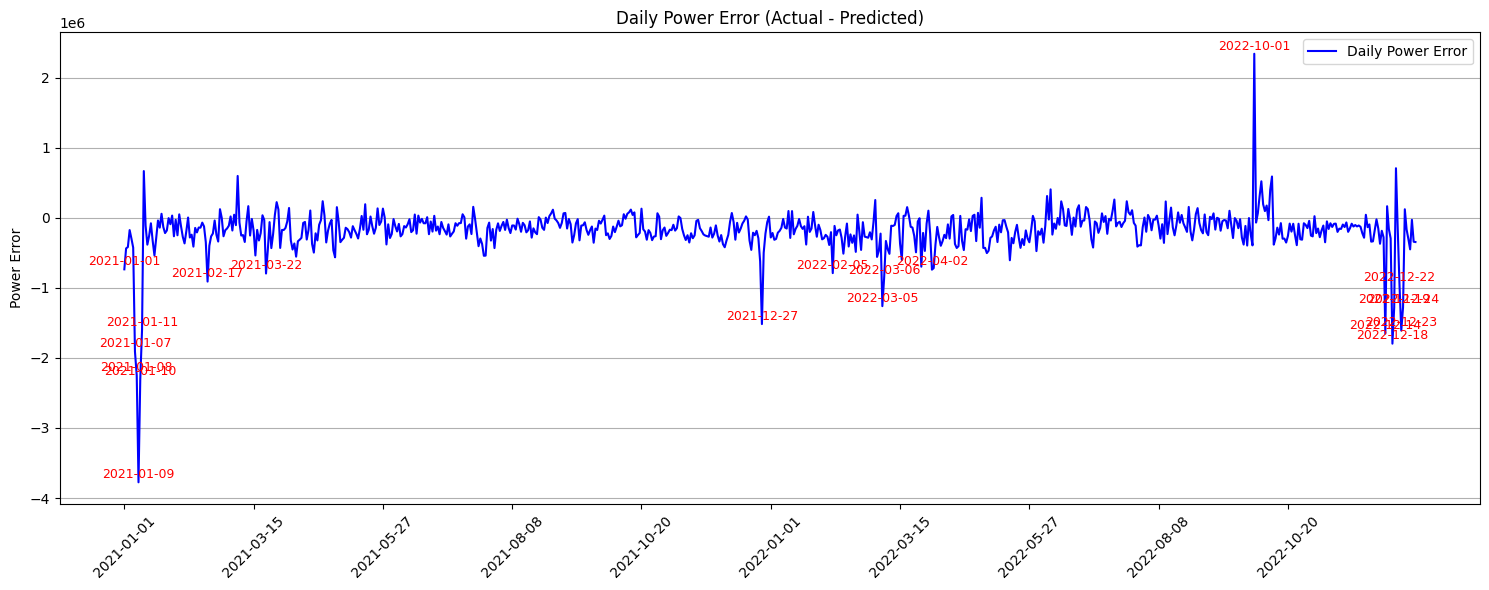

In [35]:
# 오차 계산
error = daily_actual_sum - daily_predicted_sum

# 오차와 관련된 날짜 정보를 데이터프레임으로 만들기
error_df = pd.DataFrame({
    'date': np.unique(y_test_df.index.date),
    'error': error
})

# 오차를 내림차순으로 정렬
sorted_error_df = error_df.sort_values(by='error', ascending=False)

# 상위 20개의 오차를 가진 날짜 선택
top_20_error_dates = sorted_error_df.head(20)

top_20_absolute_error_dates = error_df.iloc[np.argsort(-np.abs(error_df['error'].values))[:20]]


# 그래프 그리기
plt.figure(figsize=(15, 6))
plt.plot(error, label='Daily Power Error', color='blue')
plt.title('Daily Power Error (Actual - Predicted)')
plt.ylabel('Power Error')
plt.legend()
plt.grid(True, axis='y')

# x축에 날짜 정보 설정
dates = np.unique(y_test_df.index.date)
plt.xticks(ticks=range(0, len(dates), int(len(dates)/10)), labels=[dates[i].strftime('%Y-%m-%d') for i in range(0, len(dates), int(len(dates)/10))], rotation=45)

# 상위 20개 오차를 그래프에 주석으로 추가
for idx, row in top_20_absolute_error_dates.iterrows():
    date = row['date']
    err = row['error']
    date_idx = list(dates).index(date)
    plt.annotate(f"{date.strftime('%Y-%m-%d')}", (date_idx, err), 
                 textcoords="offset points", xytext=(0,3), ha='center', fontsize=9, color='red')

plt.tight_layout()
plt.show()

In [25]:
#train = pd.read_csv('train_data_nan.csv', index_col='DateTime')
test = pd.read_csv('test_data_nan.csv', index_col='Date')
#train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)
all_data = pd.concat([test], ignore_index=False)
all_data['Precipitation(mm)'] = all_data['Precipitation(mm)'] + 0.001
#     drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
#                     "PhenomenonNumber", "Humidity(%)", "Visibility(10m)", "aerosol", "power"]
drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
            "PhenomenonNumber", "Humidity(%)", "Visibility(10m)", "aerosol", "DewPointTemperature(C)", "VaporPressure(hPa)"]
all_data = all_data.drop(columns=drop_columns)
all_data['num_missing'] = (all_data == -1).sum(axis=1)

all_data['Precipitation(mm)'] = np.log1p(all_data['Precipitation(mm)'])

standard_cols = ['Sunshine(hr)', 
             'SolarRadiation(MJ/m2)', 'Snowfall(cm)', 'TotalCloudCoverage(1/10)']
scaler = StandardScaler()
all_data[standard_cols] = scaler.fit_transform(all_data[standard_cols])
all_data['prediction'] = cbc_oof_test_preds
all_data['actual-prediction'] = all_data['power'] - all_data['prediction']
all_data.head()

,Month,Hour,Temperature(C),Precipitation(mm),Sunshine(hr),SolarRadiation(MJ/m2),Snowfall(cm),SnowfallLast3Hours(cm),TotalCloudCoverage(1/10),MidLowCloudCoverage(1/10),LowCloud(100m),d2m,power,num_missing,prediction,actual-prediction
DateTime,,,,,,,,,,,,,,,,
2021-01-01 09:00:00,1,9,-1.50,0.00,-0.30,-0.97,4.47,0.00,-0.41,4.00,13.00,268.46,48000.00,0,159028.52,-111028.52
2021-01-01 10:00:00,1,10,0.50,-6.91,0.85,-0.24,4.10,-1.00,0.15,6.00,18.00,268.95,441600.00,1,615830.15,-174230.15
2021-01-01 11:00:00,1,11,2.00,-6.91,-0.30,-0.30,3.62,-1.00,0.43,7.00,12.00,269.55,1065600.00,1,1186282.03,-120682.03
2021-01-01 12:00:00,1,12,2.50,-6.91,-0.53,-0.24,2.53,-1.00,0.71,8.00,12.00,269.88,950400.00,1,1012530.77,-62130.77
2021-01-01 13:00:00,1,13,2.90,-6.91,-0.53,-0.24,-0.13,-1.00,0.71,8.00,16.00,270.17,2524800.00,2,2553515.19,-28715.19


In [26]:
# 'actual-prediction' 컬럼의 절대값을 기준으로 데이터를 정렬하고 상위 10개의 행을 선택합니다.
top_10_absolute_errors = all_data.loc[all_data['actual-prediction'].abs().nlargest(10).index]

top_10_absolute_errors

,Month,Hour,Temperature(C),Precipitation(mm),Sunshine(hr),SolarRadiation(MJ/m2),Snowfall(cm),SnowfallLast3Hours(cm),TotalCloudCoverage(1/10),MidLowCloudCoverage(1/10),LowCloud(100m),d2m,power,num_missing,prediction,actual-prediction
DateTime,,,,,,,,,,,,,,,,
2022-10-01 11:00:00,10,11,24.50,-6.91,-3.53,-2.30,-0.13,-1.00,-0.96,0.00,-1.00,290.30,8140800.00,5,6797345.09,1343454.91
2022-10-01 12:00:00,10,12,25.90,-6.91,-3.53,-2.30,-0.13,-1.00,-0.96,0.00,-1.00,290.60,8918400.00,5,7603176.12,1315223.88
2021-01-09 14:00:00,1,14,-3.40,-6.91,1.08,1.05,10.99,-1.00,-1.52,0.00,-1.00,264.50,230400.00,2,936188.82,-705788.82
2021-01-09 11:00:00,1,11,-6.80,-6.91,1.08,0.55,14.26,-1.00,-1.52,0.00,-1.00,266.58,96000.00,2,775669.04,-679669.04
2021-12-27 11:00:00,12,11,-3.30,-6.91,1.08,0.75,11.84,-1.00,-1.52,0.00,-1.00,270.71,38400.00,2,709764.20,-671364.20
2021-01-09 15:00:00,1,15,-2.40,-6.91,1.08,0.71,10.39,-1.00,-1.52,0.00,-1.00,265.00,240000.00,2,900647.58,-660647.58
2021-01-09 12:00:00,1,12,-5.70,-6.91,1.08,0.72,13.29,-1.00,-0.69,0.00,-1.00,265.55,172800.00,2,810021.63,-637221.63
2021-01-09 13:00:00,1,13,-4.80,-6.91,1.08,0.61,12.20,-1.00,-0.69,0.00,-1.00,265.13,211200.00,2,796015.90,-584815.90
2022-12-14 11:00:00,12,11,-2.70,-6.91,-0.07,-0.08,6.28,-1.00,-0.13,5.00,6.00,266.87,144000.00,1,698946.48,-554946.48


In [38]:
# 인덱스를 datetime 형식으로 변환
all_data.index = pd.to_datetime(all_data.index)

# "2022-10-01" 날짜에 해당하는 데이터만 선택
data_on_2022_10_01 = all_data[all_data.index.date == pd.to_datetime("2022-10-01").date()]

data_on_2022_10_01

,Month,Hour,Temperature(C),Precipitation(mm),Sunshine(hr),SolarRadiation(MJ/m2),Snowfall(cm),SnowfallLast3Hours(cm),TotalCloudCoverage(1/10),MidLowCloudCoverage(1/10),LowCloud(100m),d2m,power,num_missing,prediction,actual-prediction
DateTime,,,,,,,,,,,,,,,,
2022-10-01 07:00:00,10,7,16.50,-6.91,-1.22,-1.24,-0.13,-1.00,0.15,0.00,-1.00,289.37,105600.00,3,100089.64,5510.36
2022-10-01 08:00:00,10,8,18.50,-6.91,1.08,-0.72,-0.13,-1.00,-0.69,0.00,-1.00,289.54,1459200.00,3,1477310.02,-18110.02
2022-10-01 09:00:00,10,9,20.50,-6.91,1.08,-0.09,-0.13,-1.00,-0.69,0.00,-1.00,289.64,4214400.00,3,4272678.94,-58278.94
2022-10-01 10:00:00,10,10,22.90,-6.91,1.08,0.73,-0.13,-1.00,-1.24,0.00,-1.00,290.35,6403200.00,3,6452829.82,-49629.82
2022-10-01 11:00:00,10,11,24.50,-6.91,-3.53,-2.30,-0.13,-1.00,-0.96,0.00,-1.00,290.30,8140800.00,5,6797345.09,1343454.91
2022-10-01 12:00:00,10,12,25.90,-6.91,-3.53,-2.30,-0.13,-1.00,-0.96,0.00,-1.00,290.60,8918400.00,5,7603176.12,1315223.88
2022-10-01 13:00:00,10,13,27.10,-6.91,0.39,0.96,-0.13,-1.00,0.15,0.00,-1.00,290.77,9696000.00,3,9695308.48,691.52
2022-10-01 14:00:00,10,14,27.60,-6.91,1.08,1.64,-0.13,-1.00,0.43,0.00,-1.00,291.14,9321600.00,3,9339266.41,-17666.41
2022-10-01 15:00:00,10,15,27.20,-6.91,1.08,1.26,-0.13,-1.00,-0.41,0.00,-1.00,291.13,8044800.00,3,8053371.80,-8571.80


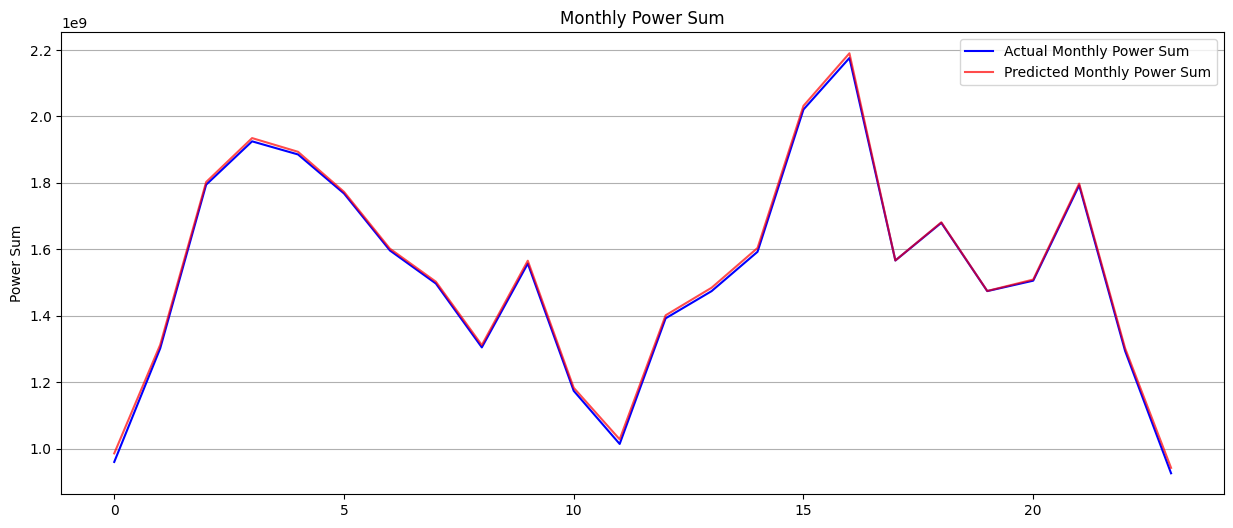

In [84]:
monthly_visualize(y_test, xgb_oof_test_preds, test.index)

In [107]:
monthly_error_bar_visualize_corrected(y_test, xgb_oof_test_preds, test.index)

ValueError: operands could not be broadcast together with shapes (24,) (12,) 

In [97]:
y_test_df = pd.DataFrame(y_test, index=pd.to_datetime(test.index), columns=['power'])
monthly_actual_sum = y_test_df.resample('M').sum().values.flatten()

monthly_predicted_sum = [np.sum(xgb_oof_test_preds[(y_test_df.index.month == month) & (y_test_df.index.year == year)]) 
                        for year in y_test_df.index.year.unique() 
                        for month in range(1, 13) 
                        if (y_test_df.index.year.unique() == year).any() and 
                           (y_test_df.index.month == month).any()]

print(len(monthly_actual_sum))
print(len(monthly_predicted_sum))


24
24


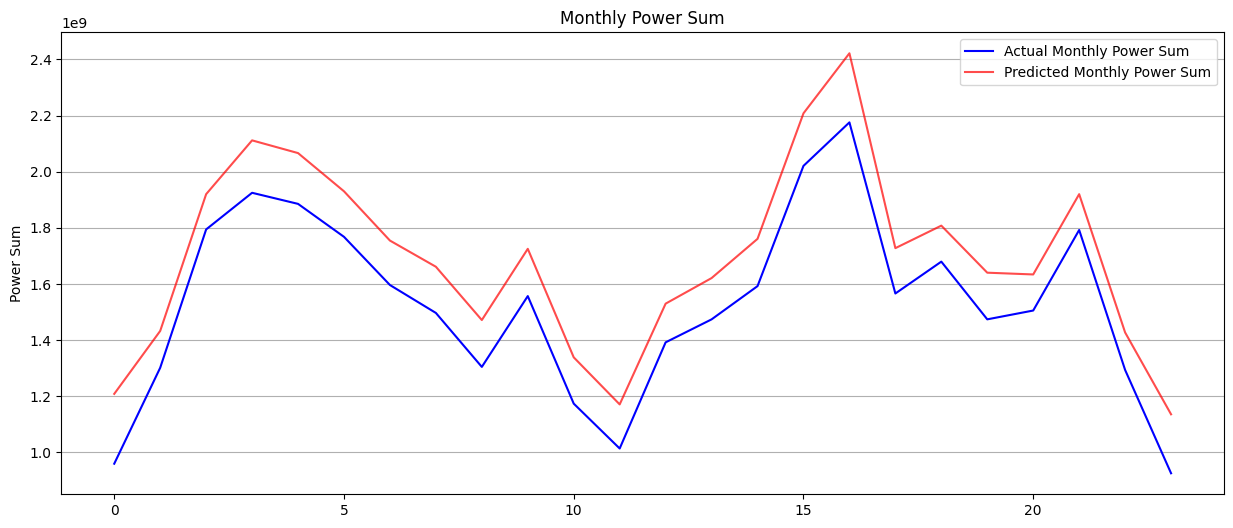

In [61]:
monthly_visualize(y_test, cbc_oof_test_preds, test.index)

# drop columns 실험실

In [79]:
train = pd.read_csv('train_data_nan.csv', index_col='Date')
test = pd.read_csv('test_data_nan.csv', index_col='Date')
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)
all_data = pd.concat([train, test], ignore_index=False)
all_data['Precipitation(mm)'] = all_data['Precipitation(mm)'] + 0.001
drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
                "PhenomenonNumber", "Humidity(%)", "Visibility(10m)", "aerosol", "DewPointTemperature(C)", "VaporPressure(hPa)"]
all_data = all_data.drop(columns=drop_columns)
all_data['num_missing'] = (all_data == -1).sum(axis=1)

all_data['Precipitation(mm)'] = np.log1p(all_data['Precipitation(mm)'])

standard_cols = ['Sunshine(hr)', 
             'SolarRadiation(MJ/m2)', 'Snowfall(cm)', 'TotalCloudCoverage(1/10)']
scaler = StandardScaler()
all_data[standard_cols] = scaler.fit_transform(all_data[standard_cols])

In [80]:
all_data.head()

,Month,Hour,Temperature(C),Precipitation(mm),Sunshine(hr),SolarRadiation(MJ/m2),Snowfall(cm),SnowfallLast3Hours(cm),TotalCloudCoverage(1/10),MidLowCloudCoverage(1/10),LowCloud(100m),d2m,power,num_missing
DateTime,,,,,,,,,,,,,,
2013-03-19 07:00:00,3,7,6.4,-6.907755,-1.176958,-1.210267,-0.09691,-1.0,0.476799,7.0,10.0,281.82224,9600.0,2
2013-03-19 08:00:00,3,8,7.2,-6.907755,-1.176958,-0.959533,-0.09691,-1.0,0.476799,7.0,10.0,281.86746,816000.0,2
2013-03-19 09:00:00,3,9,9.1,-6.907755,-0.498687,-0.425359,-0.09691,-1.0,-0.572134,3.0,10.0,282.04712,2899200.0,2
2013-03-19 10:00:00,3,10,11.1,-6.907755,1.083944,0.239634,-0.09691,-1.0,-1.358834,0.0,-1.0,282.88538,5472000.0,3
2013-03-19 11:00:00,3,11,12.9,-6.907755,1.083944,0.762906,-0.09691,-1.0,-1.358834,0.0,-1.0,282.98697,7401600.0,3


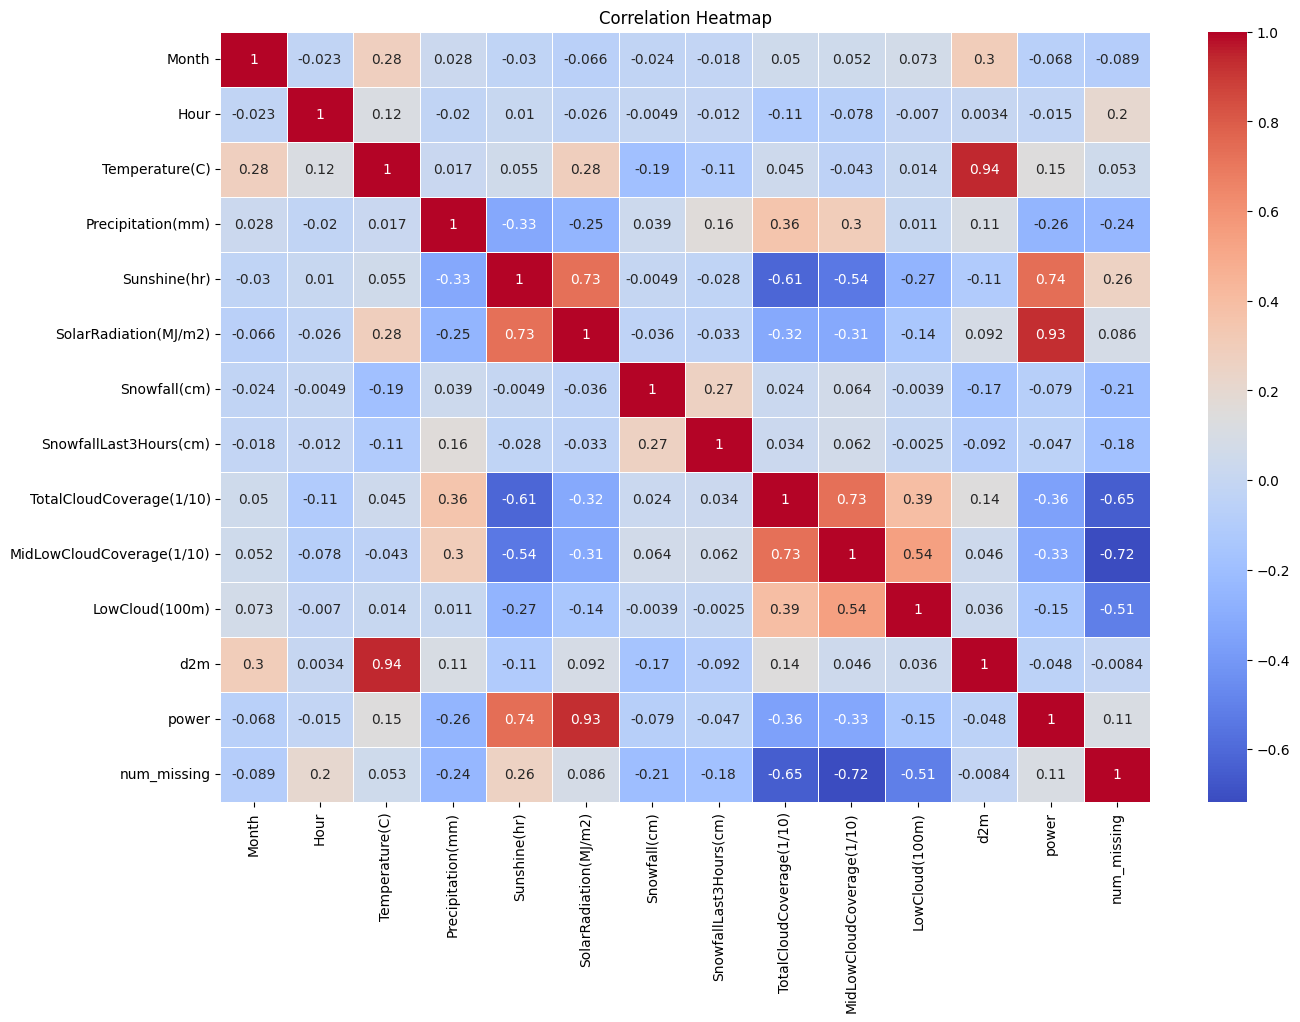

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# 상관계수 계산
correlation_matrix = all_data.corr()

# 히트맵으로 상관계수 시각화
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [88]:
train['Sunshine(hr)'].head()

DateTime
2013-03-19 07:00:00    0.0
2013-03-19 08:00:00    0.0
2013-03-19 09:00:00    0.3
2013-03-19 10:00:00    1.0
2013-03-19 11:00:00    1.0
Name: Sunshine(hr), dtype: float64

In [2]:
train = pd.read_csv('train_data_nan_wind.csv', index_col='Date')
test = pd.read_csv('test_data_nan_wind.csv', index_col='Date')
train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)
all_data = pd.concat([train, test], ignore_index=True)

#     drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
#                     "PhenomenonNumber", "Humidity(%)", "Visibility(10m)", "aerosol", "power"]
drop_columns = ["Day", "Year", "t2m", "CloudForm", "GroundState(code)", 
            "PhenomenonNumber", "aerosol", "d2m", "VaporPressure(hPa)", "Humidity(%)", 
                "Visibility(10m)", "MidLowCloudCoverage(1/10)", "LowCloud(100m)",
               "SnowfallLast3Hours(cm)"]

all_data = all_data.drop(columns=drop_columns)

In [3]:
all_data.columns

Index(['Month', 'Hour', 'Temperature(C)', 'Precipitation(mm)',
       'DewPointTemperature(C)', 'Sunshine(hr)', 'SolarRadiation(MJ/m2)',
       'Snowfall(cm)', 'TotalCloudCoverage(1/10)', 'power', 'Wind_Speed'],
      dtype='object')